In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
torch.manual_seed(1234)

Criando o modelo linear:

In [ ]:
class ModeloLinear(torch.nn.Module):
  def __init__(self):
    super(ModeloLinear, self).__init__()
    self.linear = torch.nn.Linear(2, 1, bias=False) # criando a camada linear
  
  def forward(self, x):
    return self.linear(x) #realiza o cálculo y = (w0*x0 + w1*x1)

Carregando os dados e normalizando:

Dimensão do input: torch.Size([50, 2])


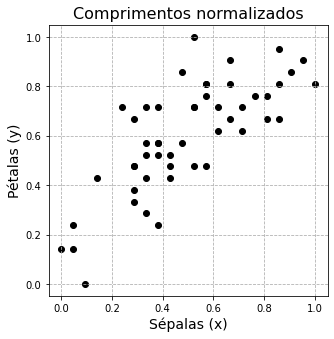

In [ ]:
# carregando os dados
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas
xt = torch.FloatTensor(data[:,0:1]).squeeze()
yt = torch.FloatTensor(data[:,1:2]).squeeze()

# normalização no intervalo [0,1]
xt_norm = (xt - xt.min())/(xt.max() - xt.min())
yt_norm = (yt - yt.min())/(yt.max() - yt.min())

# visualização
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.scatter(xt_norm, yt_norm, color='k');
ax.set_xlabel('Sépalas (x)', fontsize=14);
ax.set_ylabel('Pétalas (y)', fontsize=14);
ax.set_title('Comprimentos normalizados', fontsize=16)
ax.grid(linestyle='--');

# adicionando o bias no input
xt_norm_b = torch.stack([torch.ones_like(xt_norm), xt_norm], dim=1)
print(f'Dimensão do input: {xt_norm_b.shape}')

Definindo a função Loss que será utilizada:

In [ ]:
def Loss(pred, true):
  return ((pred - true)**2).mean(axis=-1)

Função utilizada para plotar a Loss em função de $w_1$ e $w_2$:

In [ ]:
A = np.zeros(shape=(3,3))
x = np.arange(0,3,1)
y = x.copy()
A[x,y] = 1

In [ ]:
A

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
w0 = np.arange(0,1,1e-3) # valores de w0
w1 = np.arange(0,1,1e-2) # valores de w1

ind0 = np.arange(len(w0)) # índices de w0: [1,2,...,1000]
ind1 = np.arange(len(w1)) # índices de w1: [1,2,...,1000]

indices = np.zeros(shape=(len(w0),len(w1)))
indices[ind0] = ind1

loss_grid = np.zeros(shape=(len(w0),len(w1)))
#loss_grid[id0,id1] = 1

In [ ]:
loss_grid = w0[indices[:,0]] + w1

In [ ]:
indices.shape

(1000, 100)

In [ ]:
yp[i,j] = w0[indices[j,i]] + w1[indices[i,j]]*xt_norm

In [ ]:
yp = indices.T + indices

ValueError: ignored

In [ ]:
indices

array([[ 0.,  1.,  2., ..., 97., 98., 99.],
       [ 0.,  1.,  2., ..., 97., 98., 99.],
       [ 0.,  1.,  2., ..., 97., 98., 99.],
       ...,
       [ 0.,  1.,  2., ..., 97., 98., 99.],
       [ 0.,  1.,  2., ..., 97., 98., 99.],
       [ 0.,  1.,  2., ..., 97., 98., 99.]])

In [ ]:
def plotar_colormap(ax, min=-1, max=1, step=1e-2):
  # criando um grid para w0 vs w1, o que será armazenado em um tensor (2,len(w0),len(w1))
  w_grid = np.mgrid[min:max:step, min:max:step]
  w0 = torch.Tensor(np.expand_dims(w_grid[0], axis=-1))
  w1 = torch.Tensor(np.expand_dims(w_grid[1], axis=-1))

  # calculando a loss para cada ponto do grid, resultando em uma matriz L(i,j) de dimensão (len(w0),len(w1))
  # onde cada ponto (i,j) se refere à Loss(y_pred, y) utilizando w0(i) e w1(j)
  yp = w0 + w1*xt_norm # calcula as predições para todos os valores de w0, w1 e amostras de treinamento
  loss_grid = Loss(yp, yt_norm) # calcula L(i,j)
  
  # fazendo os gráficos
  pcm = ax.pcolormesh(w0[:,0,0], w1[0,:,0], loss_grid.T, cmap='jet')
  ax.contour(w0[:,0,0], w1[0,:,0], loss_grid.T, 15, colors='k')
  cl = plt.colorbar(pcm)
  cl.set_label('Função Loss', fontsize=14)
  ax.set_xlabel('$w_0$', fontsize=14)
  ax.set_ylabel('$w_1$', fontsize=14)

Loop de treinamento e visualização:

In [ ]:
def treino(x, y, m, lr, epocas):
  # cálculo analítico dos parâmetros ótimos
  w_opt = torch.matmul(torch.matmul(torch.inverse(torch.matmul(x.T,x)),x.T),y) # inv(x.T*x)*(x.T*y)
  l_opt = Loss(torch.matmul(x, w_opt), y)
  print(f'Loss ótima: {l_opt:.4f}')

  # inicialização das listas
  we = [] # parâmetros atualizados por época
  le = [] # loss por época
  pe = [] # predições por época

  # loop de treinamento
  for e in range(epocas):
    modelo.linear.weight.requires_grad = True
    y_pred = m.forward(x) # forward
    loss = Loss(y_pred.squeeze(), y) # função custo
    loss.backward() # cálculo dos gradientes por backpropagation
    
    with torch.no_grad():
      m.linear.weight.data -= lr*m.linear.weight.grad.data # atualização

    m.linear.weight.grad.data.zero_() # zera os gradientes para a próxima época

    # armazenando os dados de interesse
    le.append(loss.detach().numpy())
    we.append(m.linear.weight.data.detach().numpy().copy())
    pe.append(y_pred.detach().numpy().squeeze())
  print(f'Loss na última época: {le[-1]:.4f}')
  
  # figuras
  fig = plt.figure(figsize=(20,5))
  ax1 = fig.add_subplot(1,3,1)
  x_grid = np.arange(0,1,0.001)
  yopt_grid = w_opt[0] + w_opt[1]*x_grid # estimativas ótimas
  for p in zip(xt_norm.numpy(), pe[-1], yt_norm.numpy()):
    plt.plot([p[0],p[0]], [p[2],p[1]], color='r', alpha=0.3)
  ax1.plot(x_grid, yopt_grid, color='k', linestyle='--')
  ax1.scatter(xt_norm, yt_norm, color='k');
  ax1.plot(xt_norm,pe[-1], marker='x', color='red')
  ax1.set_xlabel('Sépalas (x)', fontsize=14)
  ax1.set_ylabel('Pétalas (y)', fontsize=14)
  ax1.set_title('Ajuste na última época', fontsize=16)

  ax2 = fig.add_subplot(1,3,2)
  plotar_colormap(ax2) # plota Loss(w1, w2)
  for w in we: 
    ax2.scatter(w[0][0], w[0][1], color='r', marker='x') # plota os pontos
  ax2.scatter(w_opt[0], w_opt[1], color='white', marker='x') # plota o ótimo
  ax2.set_title('Evolução dos parâmetros', fontsize=16)

  ax3 = fig.add_subplot(1,3,3)
  ax3.plot(le, color='k', marker='x')
  ax3.set_ylabel('Função Loss', fontsize=14)
  ax3.set_xlabel('Época', fontsize=14)
  ax3.set_title('Função Loss por época', fontsize=16)

Loss ótima: 0.0212
Loss na última época: 0.0265


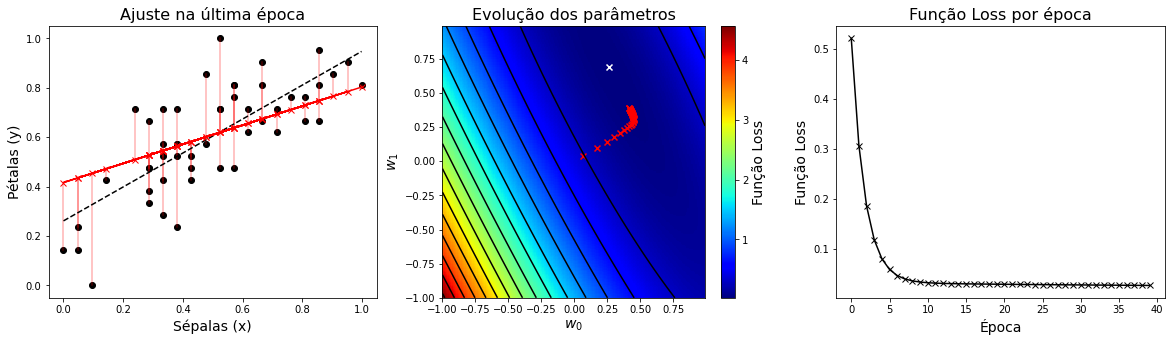

In [ ]:
modelo = ModeloLinear() # instanciando o modelo linear

treino(x = xt_norm_b, y = yt_norm, m = modelo, lr = 0.1, epocas = 40)